In [1]:
#Fetching and reading CSV files
import pandas as pd

features = 'CSV/features.csv'
train = 'CSV/train.csv'
test = 'CSV/test.csv'

features_table = pd.read_csv(features)
train_table = pd.read_csv(train)
test_table = pd.read_csv(test)


print(features_table.columns)
print(train_table.columns)
print(test_table.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')


In [2]:
#Creating a new data frame with only desired variables

exog_desvars = {
    "Temperature":features_table['Temperature'],
    "Fuel_Price":features_table['Fuel_Price'],
}
exog_df = pd.DataFrame(exog_desvars)
print(exog_df.head())

train_desvars = {
    "Date":train_table['Date'],
    "Weekly_Sales": train_table["Weekly_Sales"],
    "IsHoliday": train_table['IsHoliday']
}

train_df = pd.DataFrame(train_desvars)
print(train_df.head())

test_desvars = {
    "Date":test_table['Date'],
    "IsHoliday": test_table["IsHoliday"],
}

test_df = pd.DataFrame(test_desvars)
print(test_df.head())

   Temperature  Fuel_Price
0        42.31       2.572
1        38.51       2.548
2        39.93       2.514
3        46.63       2.561
4        46.50       2.625
         Date  Weekly_Sales  IsHoliday
0  05/02/2010      24924.50      False
1  12/02/2010      46039.49       True
2  19/02/2010      41595.55      False
3  26/02/2010      19403.54      False
4  05/03/2010      21827.90      False
         Date  IsHoliday
0  2012-11-02      False
1  2012-11-09      False
2  2012-11-16      False
3  2012-11-23       True
4  2012-11-30      False


In [3]:
# Convert IsHoliday bool type to int
train_df["IsHoliday"] = train_df["IsHoliday"].astype(int)
test_df["IsHoliday"] = test_df["IsHoliday"].astype(int)

In [18]:
# Concatenate the tables.

train_table = pd.concat([train_df,exog_df],axis=1)
train_table = train_table[:len(test_df)]
train_table

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price
0,05/02/2010,24924.50,0,42.31,2.572
1,12/02/2010,46039.49,1,38.51,2.548
2,19/02/2010,41595.55,0,39.93,2.514
3,26/02/2010,19403.54,0,46.63,2.561
4,05/03/2010,21827.90,0,46.50,2.625
...,...,...,...,...,...
115059,09/07/2010,5306.48,0,NaN,NaN
115060,16/07/2010,6814.88,0,NaN,NaN
115061,23/07/2010,7499.94,0,NaN,NaN
115062,30/07/2010,8165.34,0,NaN,NaN


In [15]:
# Concatenate the tables.
test_table = pd.concat([test_df,exog_df],axis=1)
test_table

,Date,IsHoliday,Temperature,Fuel_Price
0,2012-11-02,0,42.31,2.572
1,2012-11-09,0,38.51,2.548
2,2012-11-16,0,39.93,2.514
3,2012-11-23,1,46.63,2.561
4,2012-11-30,0,46.50,2.625
...,...,...,...,...
115059,2013-06-28,0,NaN,NaN
115060,2013-07-05,0,NaN,NaN
115061,2013-07-12,0,NaN,NaN
115062,2013-07-19,0,NaN,NaN


In [7]:
import statsmodels.api as sm
import numpy as np

# Convert data types
endog_train = np.asarray(train_table["Weekly_Sales"], dtype=np.float64)
exog_train = np.asarray(train_table[["Temperature", "Fuel_Price", "IsHoliday"]], dtype=np.float64)

# Replace inf values with NaN in training exog
exog_train[np.isinf(exog_train)] = np.nan

# Handle NaN values in training exog
exog_train_mean = np.nanmean(exog_train, axis=0)
inds_train = np.where(np.isnan(exog_train))
exog_train[inds_train] = np.take(exog_train_mean, inds_train[1])

order = (1, 0, 1)
seasonal_order = (1, 0, 1, 12)

# Create the SARIMAX model
model = sm.tsa.SARIMAX(endog_train, exog=exog_train, order=order, seasonal_order=seasonal_order)

# Fit the model
results = model.fit()

# Prepare test exog data
exog_test = np.asarray(test_table[["Temperature", "Fuel_Price", "IsHoliday"]], dtype=np.float64)

# Replace inf values with NaN in test exog
exog_test[np.isinf(exog_test)] = np.nan

# Handle NaN values in test exog using training exog mean
inds_test = np.where(np.isnan(exog_test))
exog_test[inds_test] = np.take(exog_train_mean, inds_test[1])

# Generate predictions
forecast = results.get_forecast(steps=len(test_df), exog=exog_test)
predicted_values = forecast.predicted_mean

# Print the predicted values
print(predicted_values)


[-2900.22078356 -3228.94991479 -2977.54214068 ... 15894.08761014
 15894.08761014 15894.08761014]


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_values=train_table['Weekly_Sales']

mae = mean_absolute_error(actual_values, predicted_values)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

print("mae = ",mae)
print("rmse = ", rmse)

mae =  15945.754817100977
rmse =  24529.629353764605


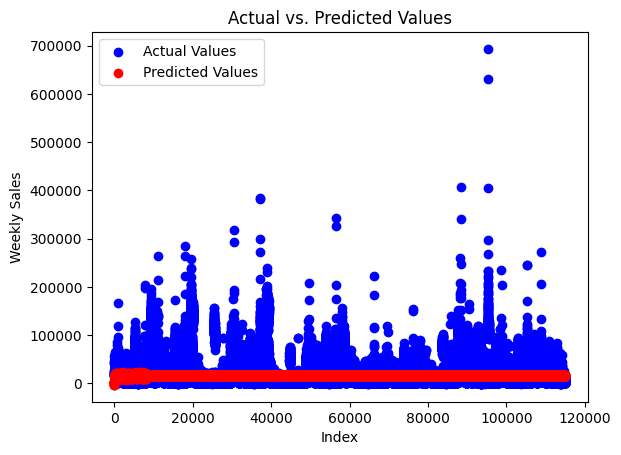

In [22]:
import matplotlib.pyplot as plt

# Plotting the predicted values and actual values
plt.scatter(range(len(actual_values)), actual_values, color='blue', label='Actual Values')
plt.scatter(range(len(predicted_values)), predicted_values, color='red', label='Predicted Values')

plt.xlabel('Index')
plt.ylabel('Weekly Sales')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()
